In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import pickle
import pmdarima as pm
from sklearn.preprocessing import StandardScaler


## 1) Importing Data 

In [2]:
sp500=yf.download('^GSPC',start="2018-01-01", end="2022-12-31",interval='1d')

[*********************100%***********************]  1 of 1 completed


In [3]:
sp500.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,2683.729980,2695.889893,2682.360107,2695.810059,2695.810059,3397430000
2018-01-03,2697.850098,2714.370117,2697.770020,2713.060059,2713.060059,3544030000
2018-01-04,2719.310059,2729.290039,2719.070068,2723.989990,2723.989990,3697340000
2018-01-05,2731.330078,2743.449951,2727.919922,2743.149902,2743.149902,3239280000
2018-01-08,2742.669922,2748.510010,2737.600098,2747.709961,2747.709961,3246160000


In [4]:
sp500['Returns %']=sp500['Adj Close'].diff() / sp500['Adj Close']

In [5]:
sp500.head()

,Open,High,Low,Close,Adj Close,Volume,Returns %
Date,,,,,,,
2018-01-02,2683.729980,2695.889893,2682.360107,2695.810059,2695.810059,3397430000,NaN
2018-01-03,2697.850098,2714.370117,2697.770020,2713.060059,2713.060059,3544030000,0.006358
2018-01-04,2719.310059,2729.290039,2719.070068,2723.989990,2723.989990,3697340000,0.004012
2018-01-05,2731.330078,2743.449951,2727.919922,2743.149902,2743.149902,3239280000,0.006985
2018-01-08,2742.669922,2748.510010,2737.600098,2747.709961,2747.709961,3246160000,0.001660


<AxesSubplot:xlabel='Date'>

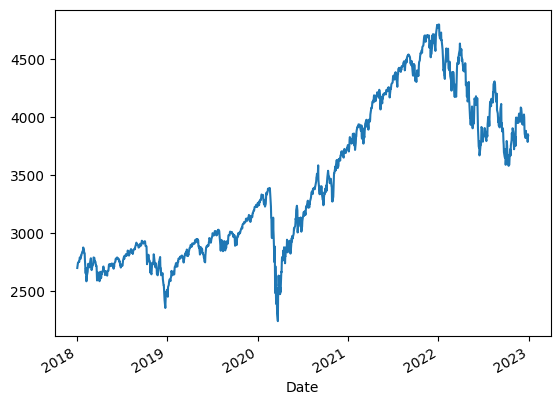

In [6]:
sp500['Adj Close'].plot()

<AxesSubplot:xlabel='Date'>

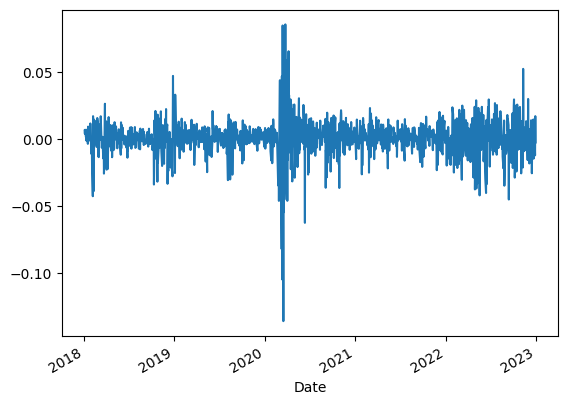

In [7]:
sp500['Returns %'].plot()

In [8]:
# sp500['Adj Close'].ewm(span=100).mean().plot()

In [9]:
# sp500['Adj Close']=sp500['Adj Close'].ewm(span=80).mean()

<AxesSubplot:xlabel='Date'>

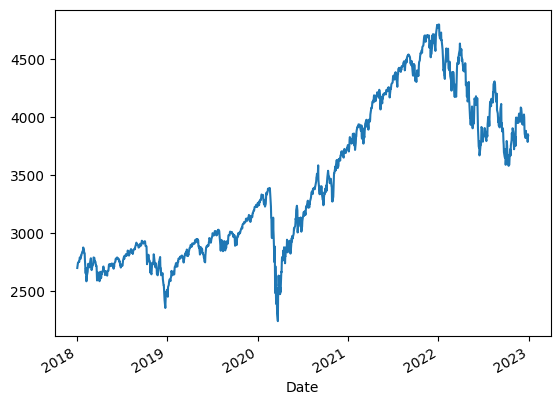

In [10]:
sp500['Adj Close'].plot()

The cyclical component represents phenomena that happen across seasonal periods. Cyclical patterns do not have a fixed period like seasonal patterns do. An example of a cyclical pattern is the cycles of boom and bust that stock markets experience in response to world events. <br>
This data seems to have cyclical component with no consistent cyclicity. So instead of decomposing it into trend, seasonality, noise, we would just keep it as it is.

In [11]:
sp500['Adj Close'].shape

(1259,)

Figure(640x480)


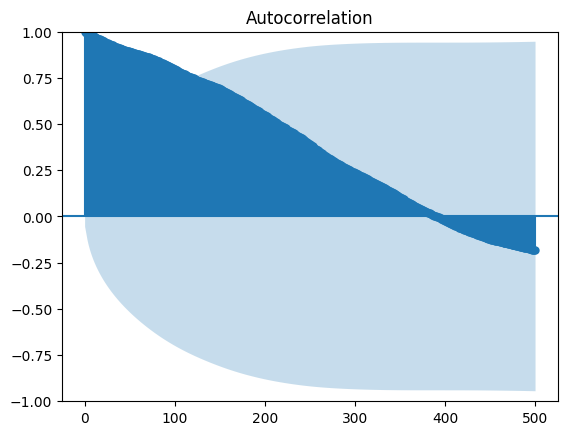

In [12]:
print(plot_acf(sp500['Adj Close'],lags=500))

Also autocorrelation graph shows no seasonal pattern.

## 4) Model

In [13]:
sp500.loc[~np.isnan(np.array(sp500['Returns %'])),'Returns %']

Date
2018-01-03    0.006358
2018-01-04    0.004012
2018-01-05    0.006985
2018-01-08    0.001660
2018-01-09    0.001301
                ...   
2022-12-23    0.005834
2022-12-27   -0.004066
2022-12-28   -0.012167
2022-12-29    0.017162
2022-12-30   -0.002547
Name: Returns %, Length: 1258, dtype: float64

In [15]:
sp500.head()

,Open,High,Low,Close,Adj Close,Volume,Returns %
Date,,,,,,,
2018-01-02,2683.729980,2695.889893,2682.360107,2695.810059,2695.810059,3397430000,NaN
2018-01-03,2697.850098,2714.370117,2697.770020,2713.060059,2713.060059,3544030000,0.006358
2018-01-04,2719.310059,2729.290039,2719.070068,2723.989990,2723.989990,3697340000,0.004012
2018-01-05,2731.330078,2743.449951,2727.919922,2743.149902,2743.149902,3239280000,0.006985
2018-01-08,2742.669922,2748.510010,2737.600098,2747.709961,2747.709961,3246160000,0.001660


In [16]:
sar = sm.tsa.statespace.SARIMAX(np.log(sp500.loc[~np.isnan(np.array(sp500['Returns %'])),'Returns %']+1), 
                                order=(2,0,0), 
                                seasonal_order=(0,0,1,50), 
                                trend='c').fit()
sar.summary()

# sarima model without seasonality is arima model

C:\Users\hp\miniconda3\envs\kirtesh\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\envs\kirtesh\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            Returns %   No. Observations:                 1258
Model:             SARIMAX(2, 0, 0)x(0, 0, [1], 50)   Log Likelihood                3608.410
Date:                              Fri, 10 Mar 2023   AIC                          -7206.820
Time:                                      01:53:26   BIC                          -7181.134
Sample:                                           0   HQIC                         -7197.167
                                             - 1258                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   8.616e-05      0.000      0.195      0.845      -0.001       0.001
ar.L1         -0.1566      0.013    -11.718      0.000      -0.183      -0.130
ar.L2          0.1077      0.012      8.993      0.000       0.084       0.131
ma.S.L50      -0.0006      0.033     -0.018      0.985      -0.065       0.064
sigma2         0.0002   2.97e-06     63.513      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             10028.29
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.64   Skew:                            -1.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
'''sar = sm.tsa.statespace.SARIMAX(np.log(sp500.loc[~np.isnan(np.array(sp500['Returns %'])),'Returns %']+1), 
                                order=(1,0,1), 
                                seasonal_order=(0,0,0,0), 
                                trend='c').fit()
sar.summary() '''

"sar = sm.tsa.statespace.SARIMAX(np.log(sp500.loc[~np.isnan(np.array(sp500['Returns %'])),'Returns %']+1), \n                                order=(1,0,1), \n                                seasonal_order=(0,0,0,0), \n                                trend='c').fit()\nsar.summary() "

In [42]:
# non seasonal
pm.auto_arima(np.log(sp500.loc[~np.isnan(np.array(sp500['Returns %'])),'Returns %']+1),start_p=1, start_q=1,
                           max_p=3, max_q=3, m=50, 
                           start_P=1, D=0, start_Q=1, max_P=3, max_D=0, max_Q=3,
                               seasonal=False,
                           d=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

C:\Users\hp\miniconda3\envs\kirtesh\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (50) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-7203.951, Time=1.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-7160.885, Time=0.30 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-7198.099, Time=0.39 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-7189.683, Time=0.39 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-7208.560, Time=1.82 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-7210.756, Time=0.76 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-7210.809, Time=1.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-7208.356, Time=1.10 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-7208.862, Time=0.96 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Total fit time: 7.940 seconds


ARIMA(order=(3, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [43]:
# seasonal
pm.auto_arima(np.log(sp500.loc[~np.isnan(np.array(sp500['Returns %'])),'Returns %']+1),start_p=1, start_q=1,
                           max_p=3, max_q=3, m=50, 
                           start_P=1, D=0, start_Q=1, max_P=3, max_D=0, max_Q=3,
                               seasonal=True,
                           d=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[50] intercept   : AIC=-7197.530, Time=36.69 sec
 ARIMA(0,0,0)(0,0,0)[50] intercept   : AIC=-7158.933, Time=0.69 sec
 ARIMA(1,0,0)(1,0,0)[50] intercept   : AIC=-7194.215, Time=30.10 sec
 ARIMA(0,0,1)(0,0,1)[50] intercept   : AIC=-7185.759, Time=24.46 sec
 ARIMA(0,0,0)(0,0,0)[50]             : AIC=-7160.885, Time=0.27 sec
 ARIMA(1,0,1)(0,0,1)[50] intercept   : AIC=-7199.538, Time=29.51 sec
 ARIMA(1,0,1)(0,0,0)[50] intercept   : AIC=-7201.500, Time=1.17 sec
 ARIMA(1,0,1)(1,0,0)[50] intercept   : AIC=-7199.538, Time=31.10 sec
 ARIMA(0,0,1)(0,0,0)[50] intercept   : AIC=-7187.750, Time=1.07 sec
 ARIMA(1,0,0)(0,0,0)[50] intercept   : AIC=-7196.168, Time=0.70 sec
 ARIMA(2,0,1)(0,0,0)[50] intercept   : AIC=-7206.617, Time=1.61 sec
 ARIMA(2,0,1)(1,0,0)[50] intercept   : AIC=-7204.654, Time=22.44 sec
 ARIMA(2,0,1)(0,0,1)[50] intercept   : AIC=-7204.625, Time=20.50 sec
 ARIMA(2,0,1)(1,0,1)[50] intercept   : AIC=-7202.623, Time=24.44 s

ARIMA(order=(3, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 50),
      suppress_warnings=True, with_intercept=False)

In [44]:
'''with open('nifty_08_12.pkl', 'wb') as f:
    pickle.dump(sar, f) '''

"with open('nifty_08_12.pkl', 'wb') as f:\n    pickle.dump(sar, f) "

In [17]:
'''with open('nifty_08_12.pkl', 'rb') as f:
    sar = pickle.load(f) '''

"with open('nifty_08_12.pkl', 'rb') as f:\n    sar = pickle.load(f) "

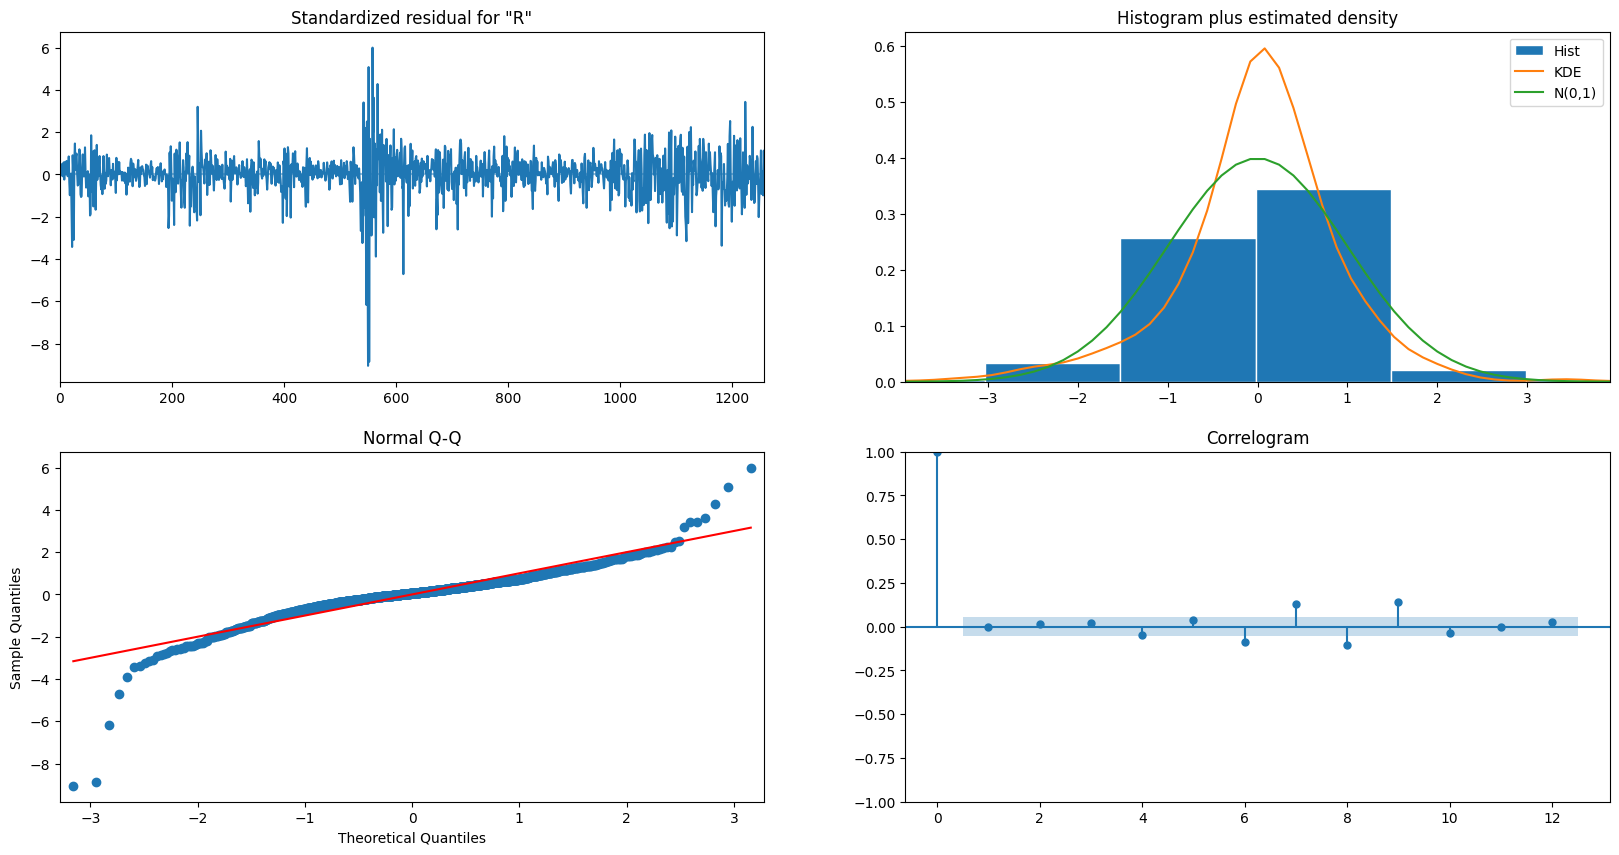

In [18]:
import matplotlib.pyplot as plt
sar.plot_diagnostics(lags=12,figsize = (20,10),)
plt.savefig('ppt_pics/residual_diag_sp500_18_22.png')

<AxesSubplot:xlabel='Date'>

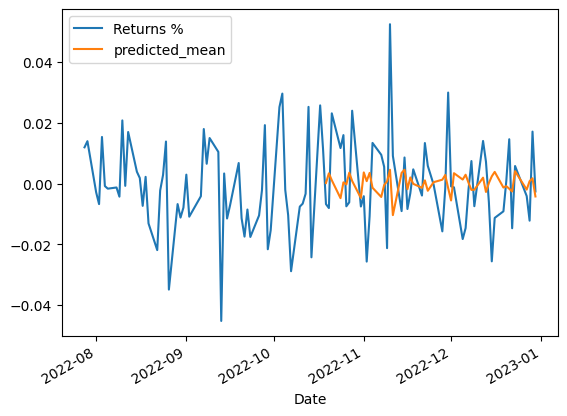

In [57]:
pd.plotting.register_matplotlib_converters()
#use model.predict() start and end in relation to series
 

sp500['Returns %'][1150:].plot(legend=True)
sar.predict(start=1207).plot(legend=True)
# sar.predict(start=1207,dynamic=True).plot(legend=True)
# sar.forecast(steps=100).plot()
# sp500[730:][['Adj Close', 'Adj Close Forecast']].plot();

In [58]:
def accuracy_sarimax(df1,df2):
    x=np.sign(np.array(df1))==np.sign(np.array(df2))
    
    return sum(x) / len(x)

In [59]:
accuracy_sarimax(np.log(sp500.loc[~np.isnan(np.array(sp500['Returns %'])),'Returns %']+1),sar.predict())

0.5

In [47]:
# sp500_fore=yf.download('^GSPC',start="2016-01-01", end="2016-05-15",interval='1d')
# sp500_fore['Adj Close']

In [48]:
# sp500_fore['Returns %']=sp500_fore['Adj Close'].diff() / sp500_fore['Adj Close']

In [49]:
# np.log(sp500_fore.loc[~np.isnan(np.array(sp500_fore['Returns %'])),'Returns %']+1)

In [50]:
# np.log(sp500.loc[~np.isnan(np.array(sp500['Returns %'])),'Returns %']+1).append(sp500_fore['Adj Close'])